In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Thu Feb  8 19:06:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 43%   72C    P2             290W / 450W |  16993MiB / 24564MiB |     88%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Hyper-Parameters

In [3]:
from easydict import EasyDict
hp = EasyDict()

# Data
hp.dataset = 'ffhq_256'
hp.data_root = '/home/scpark/data'
hp.test_eval = True
hp.image_channels = 3
hp.n_batch = 32

# Model
hp.custom_width_str = ""
hp.bottleneck_multiple = 0.25
hp.no_bias_above = 64
hp.num_mixtures = 10
hp.width = 384
hp.zdim = 16
# hp.dec_blocks = "1x1,4m1,4x2,8m4,8x5,16m8,16x10,32m16,32x21"
# hp.enc_blocks = "32x11,32d2,16x6,16d2,8x6,8d2,4x3,4d4,1x3"

hp.dec_blocks = "1x2,4m1,4x2,8m4,8x2,16m8,16x2,32m16,32x2"
hp.enc_blocks = "32x2,32d2,16x2,16d2,8x2,8d2,4x2,4d4,1x2"

# Train
hp.lr = 0.0002
hp.wd = 0.01
hp.adam_beta1 = 0.9
hp.adam_beta2 = 0.9
hp.warmup_iters = 100
hp.ema_rate = 0.9999
hp.grad_clip = 200.0
hp.skip_threshold = 400.0

### Model

In [4]:
from model.main.vdvae import Model
from model.encoder.vdvae_encoder import Encoder
from model.decoder.vdvae_decoder import Decoder
from model.loss.dmol import Loss

from tensorboardX import SummaryWriter
from util.util import *

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(hp), Decoder(hp), Loss(hp)).to(device)
ema_model = None
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=hp.wd, lr=hp.lr, betas=(hp.adam_beta1, hp.adam_beta2))

for name, module in model.named_modules():
    if len(name.split('.')) <= 1 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 11.748779296875
decoder 37.779541015625
loss 0.1468658447265625
done


### Load

In [6]:
save_dir = '/data/save/lse/train_vdvae/train02.08-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, optimizer = load(save_dir, 10000, model, optimizer)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from data.vdvae_data import set_up_data

hp, data_train, data_valid_or_test, preprocess_fn = set_up_data(hp)
hp.image_size = 32
train_loader = DataLoader(data_train, batch_size=hp.n_batch, drop_last=True, pin_memory=True)
print(train_loader)

DOING TEST


### Train

In [8]:
import time
from util.train_helpers import update_ema

def training_step(H, data_input, target, model, ema_model, optimizer):
    model.train()
    model.zero_grad()
    data = {'x': data_input,
            'x_target': target}
    stats = model.forward(data)
    stats['elbo'].backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), H.grad_clip).item()
    distortion_nans = torch.isnan(stats['distortion']).sum()
    rate_nans = torch.isnan(stats['rate']).sum()
    stats.update(dict(rate_nans=0 if rate_nans == 0 else 1, distortion_nans=0 if distortion_nans == 0 else 1))

    skipped_updates = 1
    # only update if no rank has a nan and if the grad norm is below a specific threshold
    if stats['distortion_nans'] == 0 and stats['rate_nans'] == 0 and (H.skip_threshold == -1 or grad_norm < H.skip_threshold):
        optimizer.step()
        skipped_updates = 0
        if ema_model is not None:
            update_ema(model, ema_model, H.ema_rate)

    stats.update(skipped_updates=skipped_updates, grad_norm=grad_norm)
    return stats

def show_samples(model, N):
    model.eval()
    with torch.no_grad():
        samples = model.sample(N)
    plt.figure(figsize=[18, 4])
    for i in range(len(samples)):
        plt.subplot(1, N, i+1)
        plt.imshow(samples[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

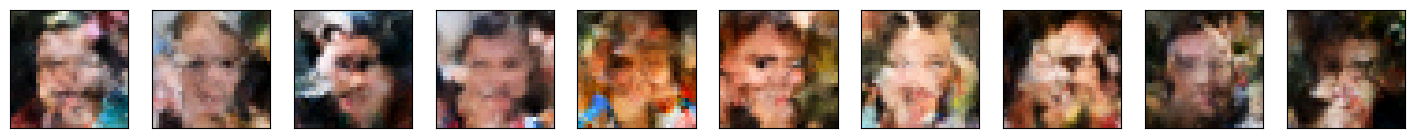

6010 elbo 1.225429892539978
6020 elbo 1.1982886791229248
6030 elbo 1.2134387493133545
6040 elbo 1.2282716035842896
6050 elbo 1.2263238430023193
6060 elbo 1.2069416046142578
6070 elbo 1.2519543170928955
6080 elbo 1.2486321926116943
6090 elbo 1.2675470113754272
6100 elbo 1.2502539157867432
6110 elbo 1.2029027938842773
6120 elbo 1.2470661401748657
6130 elbo 1.158202052116394
6140 elbo 1.2129578590393066
6150 elbo 1.2456605434417725
6160 elbo 1.2273623943328857
6170 elbo 1.2086689472198486
6180 elbo 1.229385256767273
6190 elbo 1.2281289100646973
6200 elbo 1.230400800704956
6210 elbo 1.2279869318008423
6220 elbo 1.2038750648498535
6230 elbo 1.262190341949463
6240 elbo 1.2079193592071533
6250 elbo 1.2095829248428345
6260 elbo 1.2073545455932617
6270 elbo 1.2188236713409424
6280 elbo 1.186822772026062
6290 elbo 1.2860581874847412
6300 elbo 1.2290232181549072
6310 elbo 1.2493757009506226
6320 elbo 1.1798219680786133
6330 elbo 1.1975085735321045
6340 elbo 1.238800287246704
6350 elbo 1.287146925

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import torchvision.transforms as transforms

resize = transforms.Resize((hp.image_size, hp.image_size))

while True:
    for x in train_loader:
        x[0] = resize(x[0].permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        data_input, target = preprocess_fn(x)
        data_input = data_input.to(device)
        target = target.to(device)
        stats = training_step(hp, data_input, target, model, ema_model, optimizer)

        if step % 10 == 0:
            print(step, 'elbo', stats['elbo'].item())
            writer.add_scalar('elbo', stats['elbo'].item(), step)
            writer.add_scalar('distortion', stats['distortion'].item(), step)
            writer.add_scalar('rate', stats['rate'].item(), step)
            
        if step % 1000 == 0:
            display.clear_output()
            show_samples(model, 10)
            
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        

In [ ]:
save(save_dir, step, model, optimizer)
print('done')

In [ ]:
display.clear_output()
show_samples(model, 10)